In [1]:
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob

In [ ]:
expname = 'CM4'
varname = 'slp'

exppath = {
    'CM4' : '/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148_rerun/gfdl.ncrc5-intel22-prod-openmp/pp/',
    'ESM4': '/archive/Katherine.Turner/fre/FMS2021.02_mom6_ESM4_v1.0.3/ESM4_piControl_D/gfdl.ncrc5-intel23-prod-openmp/pp/'
}

fpath ={
    'slp': f'{exppath[expname]}atmos/ts/6hr/5yr/*.slp.nc',
    'vort500': f'{exppath[expname]}atmos/ts/6hr/5yr/*.vort500.nc',
    'vort850': f'{exppath[expname]}atmos/ts/6hr/5yr/*.vort850.nc',
    'zg': f'{exppath[expname]}atmos_cmip_2deg_daily_3D/ts/daily/5yr/*.zg.nc',
}

freq ={
    'slp': 0.25,
    'vort500': 0.25,
    'vort850': 0.25,
    'zg': 1,
}

In [ ]:
ds = xr.open_mfdataset('/work/Katherine.Turner/tempest-extremes/odiv-251/data/atmos.*.slp.nc', use_cftime=True)

In [ ]:
ds_out = ds.sel(lat=slice(-90,-30)).chunk({'time':138700, 'lat':15, 'lon':48})
ds_out.to_zarr('/xtmp/Katherine.Turner/work/storm_timeseries/CM4_slp')

In [2]:
ds = xr.open_zarr('/xtmp/Katherine.Turner/work/storm_timeseries/CM4_slp')

In [3]:
ds_daily = ds.isel(time=slice(1,None,4))

In [6]:
ds_daily.chunk({'time':34675, 'lat':60, 'lon':48}).to_zarr('/xtmp/Katherine.Turner/work/storm_timeseries/CM4_slp_daily')

In [7]:
ds = xr.open_zarr('/xtmp/Katherine.Turner/work/storm_timeseries/CM4_slp_daily')
varname='slp'
ts_shape = ds[varname].shape

In [8]:
filtered = np.ones(shape=ts_shape)*np.nan
sos = signal.butter(4, 1/7, btype='high', fs=1, output='sos')

for i in range(ts_shape[1]):
    for j in range(ts_shape[2]):
        sig = ds[varname][:,i,j].data
        filtered[:,i,j] = signal.sosfilt(sos, sig)
    if i%10 == 0:
        print(i)
        
ds_out = xr.Dataset(
    data_vars=dict(
        slp_bp_7d=(["time", "lat", "lon"], filtered),
    ),
    coords=dict(
        lon=("lon", ds.lon.data),
        lat=("lat", ds.lat.data),
        time=ds.time.data,
    ),
    attrs=dict(description=f"Bandpass-filtered slp for CM4"),
)

ds_out = ds_out.chunk({'time':34675, 'lat':60, 'lon':48})
ds_out.to_zarr(f'/xtmp/Katherine.Turner/work/storm_timeseries/CM4_slp_daily_highpassed_7d')

0
10
20
30
40
50


In [14]:
ds = xr.open_zarr(f'/xtmp/Katherine.Turner/work/storm_timeseries/CM4_slp_daily_highpassed_7d')

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

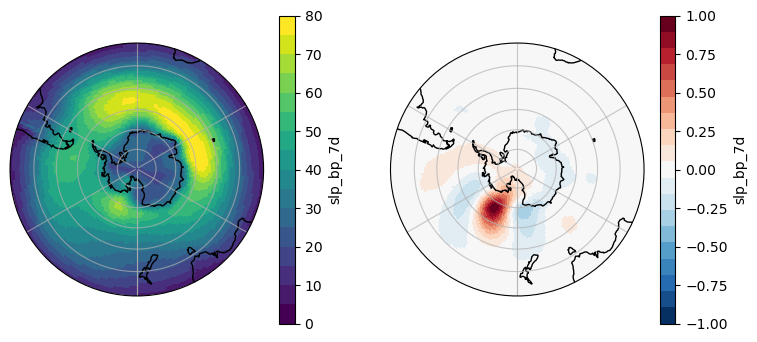

In [72]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9,4), 
                        subplot_kw={'projection':ccrs.SouthPolarStereo()})
axs = axs.flatten()

variance.plot(ax=axs[0],
              transform=ccrs.PlateCarree(),
              vmin=0, vmax=80, extend='neither',
              cmap=plt.get_cmap("viridis",16)
             )

corrfield.plot(ax=axs[1], 
          transform=ccrs.PlateCarree(),
          vmin=-1, vmax=1, extend='neither',
          cmap=plt.get_cmap("RdBu_r",19)
                                  )

for i in np.arange(2):
    axs[i].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

In [71]:
variance = (1e-2*ds.slp_bp_7d[idx_winter,:,:]).var(dim='time')
variance = variance.compute()

lat0 = variance.argmax(dim=['lat', 'lon'])['lat']
lon0 = variance.argmax(dim=['lat', 'lon'])['lon']

lat0=-67
lon0=210


slp_pt = ds.slp_bp_7d[idx_winter,:,:].sel(lat=lat0, lon=lon0, method='nearest')
slp_pt = slp_pt.load()

corrfield = xr.corr(ds.slp_bp_7d[idx_winter,:,:], slp_pt, dim='time')
corrfield = corrfield.compute()

In [60]:
idx_winter = (ds.time.dt.month >= 4) & (ds.time.dt.month <= 9)